In [ ]:
!pip install --quiet cirq
!pip install --quiet bayesian-optimization

     |████████████████████████████████| 1.6MB 5.6MB/s 


In [ ]:
from bayes_opt import BayesianOptimization
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
import cirq
from cirq.contrib.svg import SVGCircuit
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import sympy
from time import time

In [ ]:
def plot_target(optimizer, init_p, iter, c: int = 20, smooth: bool = False):
    targets = [r["target"] for r in optimizer.res]
    assert len(targets) == init_p + iter
    plt.figure(figsize=(12,8))
    plt.title("Optimization Process")
    plt.xlabel("Step")
    plt.ylabel("Objective")
    plt.ylim(-0.05, 1.05)
    plt.hlines(y=0.75, xmin=0, xmax=len(targets), linestyles='dashed', label='Classical limit', colors='g')
    plt.hlines(y=0.853, xmin=0, xmax=len(targets), linestyles='dashed', label='Quantum limit', colors='black')
    plt.plot(range(init_p-1, init_p + iter), targets[init_p-1:], linewidth=0.5, c='b', marker='.', markersize=5)
    plt.plot(range(0, init_p), targets[:init_p], c='r', linewidth=0.5, marker='.', markersize=5)
    if smooth:
        plt.plot(range(0, init_p + iter), savgol_filter(targets, 31, 3), linewidth=2, c='black')
    plt.legend()
    plt.grid(linestyle='dotted')
    plt.show()

In [ ]:
# Fix a random seed
RANDOM_SEED = 1234

# Fix the number of simulations per step
REPETITIONS = 1000

# Init the qubits
x, a, y, b = cirq.GridQubit.rect(1, 4)
QUBITS = (x, a, y, b)
print(QUBITS)

# Init the simulator
QUANT_SIMULATOR = cirq.Simulator(seed=RANDOM_SEED)

# Optimization: number of random steps
INIT_P = 300
# Optimization: number of steps
ITER = 100

(cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3))


# Entangling: off

In [ ]:
def build_vqc_no_ent(qubits, symbols, add_measurement=False):

    (x, a, y, b) = qubits
    circ = cirq.Circuit()
    
    # "Classical" section
    circ.append([cirq.H(x), cirq.H(y)])
    circ.append([cirq.measure(x, key='x'), cirq.measure(y, key='y')], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    
    # Layer 1
    circ.append([cirq.H(a), cirq.H(b)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rz(symbols[0])(a), 
                 cirq.rz(symbols[1])(b)])
    circ.append([cirq.rx(symbols[2])(a), 
                 cirq.rx(symbols[3])(b)])
    
    # Layer 2
    circ.append([cirq.H(a), cirq.H(b)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rz(symbols[4])(a), 
                 cirq.rz(symbols[5])(b)])
    circ.append([cirq.rx(symbols[6])(a), 
                 cirq.rx(symbols[7])(b)])
    
    # Layer 3
    circ.append([cirq.H(a), cirq.H(b)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rz(symbols[8])(a), 
                 cirq.rz(symbols[9])(b)])
    circ.append([cirq.rx(symbols[10])(a), 
                 cirq.rx(symbols[11])(b)])

    circ.append([cirq.CX(x, a)**symbols[12], 
                 cirq.CX(y, b)**symbols[13]])
    
    # Measurement
    if add_measurement:
        circ.append([cirq.measure(a, key='a'), cirq.measure(b, key='b')], 
                    strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    return circ

def simulate_vqc_no_ent(x00, x01, x02, x03, x04, x05, x06, x07, x08, x09, x10, x11, x12, x13):
    param_vals = (x00, x01, x02, x03, x04, x05, x06, x07, x08, x09, x10, x11, x12, x13)
    param_res = cirq.ParamResolver({PARAM_SYMBOLS_NO_ENT[i] : param_vals[i] for i in range(len(param_vals))})
    sim_results = QUANT_SIMULATOR.run(VQC_NO_ENT, param_res, repetitions=REPETITIONS)
    df = sim_results.data.astype(np.bool)
    wins = (np.logical_and(df['x'], df['y']) == np.logical_xor(df['a'], df['b'])).astype(np.int8)
    win_pct = len(wins[wins == 1]) / len(wins)
    return win_pct

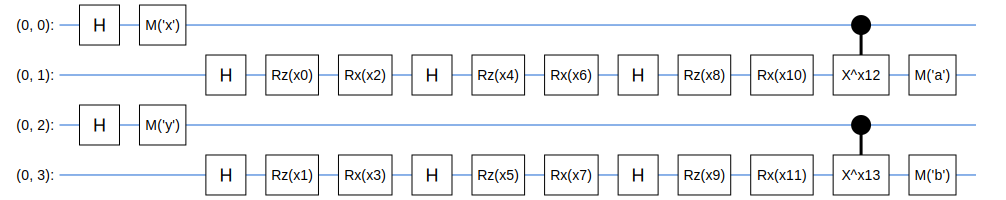

In [ ]:
PARAM_SYMBOLS_NO_ENT = sympy.symbols('x0:14')
VQC_NO_ENT = build_vqc_no_ent(qubits=QUBITS, symbols=PARAM_SYMBOLS_NO_ENT, add_measurement=True)
SVGCircuit(VQC_NO_ENT)

|   iter    |  target   |    x00    |    x01    |    x02    |    x03    |    x04    |    x05    |    x06    |    x07    |    x08    |    x09    |    x10    |    x11    |    x12    |    x13    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  2        |  0.494    |  2.326    |  3.526    |  3.161    |  0.08651  |  4.856    |  5.546    |  2.293    |  3.867    |  0.4736   |  2.317    |  5.863    |  4.093    | -0.4112   |  1.155    |
|  4        |  0.582    |  0.2975   |  4.24     |  3.736    |  3.351    |  0.2722   |  3.528    |  2.071    |  3.16     |  0.7031   |  3.815    |  3.556    |  0.0425   |  0.4698   |  1.648    |
|  20       |  0.655    |  4.35     |  2.968    |  5.384    |  4.177    |  2.095    |  3.256    |  2.48     |  0.1951   |  3.624    |  5.342    |  5.978    |  4.291    | -1.695    | -0.3597   |
|  51       |  0.661    |  4.4

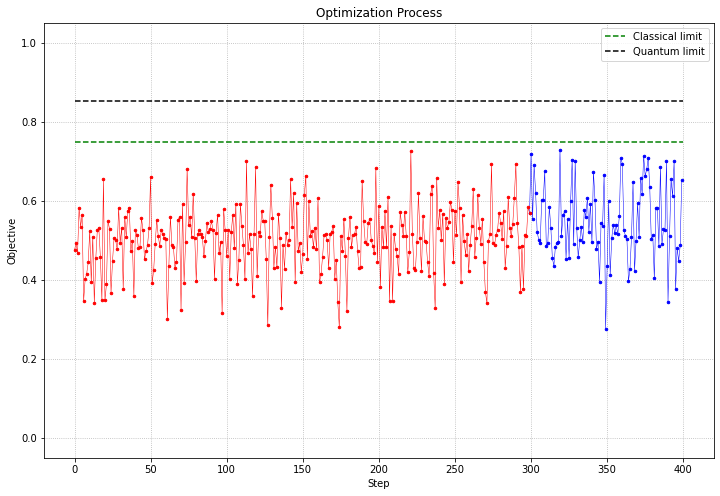

In [ ]:
pbounds_no_ent = {'x00': (0, 2 * np.pi), 'x01': (0, 2 * np.pi), 
                  'x02': (0, 2 * np.pi), 'x03': (0, 2 * np.pi),
                  'x04': (0, 2 * np.pi), 'x05': (0, 2 * np.pi),
                  'x06': (0, 2 * np.pi), 'x07': (0, 2 * np.pi),
                  'x08': (0, 2 * np.pi), 'x09': (0, 2 * np.pi),
                  'x10': (0, 2 * np.pi), 'x11': (0, 2 * np.pi),
                  'x12': (-2, 2), 'x13': (-2, 2)}

optimizer_no_ent = BayesianOptimization(
    f=simulate_vqc_no_ent,
    pbounds=pbounds_no_ent,
    verbose=1,
    random_state=RANDOM_SEED,
)

start = time()
optimizer_no_ent.maximize(
    init_points=INIT_P,
    acq='poi',
    n_iter=ITER,
)
end = time()

print(f"\nOptimum = {optimizer.max}")

print(f"\nTook {round((end - start)/ 60, 2)} min\n")

plot_target(optimizer=optimizer_no_ent, init_p=INIT_P, iter=ITER)

In [ ]:
best_params_no_ent = optimizer_no_ent.max["params"]
(x00, x01, x02, x03, x04, x05, x06, x07, x08, x09, x10, x11, x12, x13) = best_params_no_ent.values()

result_no_ent = simulate_vqc_no_ent(x00, x01, x02, x03, x04, x05, x06, x07, x08, x09, x10, x11, x12, x13)
print(f"Best result obtained (without entanglement): {result_no_ent}")

Best result obtained (without entanglement): 0.726


# Entangling: on

In [ ]:
def build_vqc(qubits, symbols, add_measurement=False):

    (x, a, y, b) = qubits
    circ = cirq.Circuit()
    
    # "Classical" section
    circ.append([cirq.H(x), cirq.H(y)])
    circ.append([cirq.measure(x, key='x'), cirq.measure(y, key='y')])
    
    # VQC
    circ.append([cirq.H(b), cirq.H(a)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rz(symbols[0])(a),
                 cirq.rz(symbols[1])(b)], 
                strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circ.append([cirq.rx(symbols[2])(a), 
                 cirq.rx(symbols[3])(b)])
    circ.append([cirq.CX(b, a)**symbols[4]])

    circ.append([cirq.CX(x, a)**symbols[5], 
                 cirq.CX(y, b)**symbols[6]])
    
    # Measurement
    if add_measurement:
        circ.append([cirq.measure(a, key='a'), 
                     cirq.measure(b, key='b')], 
                    strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    return circ

def simulate_vqc(x00, x01, x02, x03, x04, x05, x06):
    param_vals = (x00, x01, x02, x03, x04, x05, x06)
    param_res = cirq.ParamResolver({PARAM_SYMBOLS[i] : param_vals[i] for i in range(len(param_vals))})
    sim_results = QUANT_SIMULATOR.run(VQC, param_res, repetitions=REPETITIONS)
    df = sim_results.data.astype(np.bool)
    wins = (np.logical_and(df['x'], df['y']) == np.logical_xor(df['a'], df['b'])).astype(np.int8)
    win_pct = len(wins[wins == 1]) / len(wins)
    return win_pct

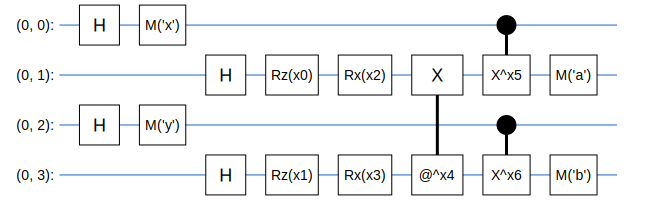

In [ ]:
# Init the symbols
PARAM_SYMBOLS = sympy.symbols('x0:7')

# Build the circuit
VQC = build_vqc(qubits=QUBITS, symbols=PARAM_SYMBOLS, add_measurement=True)

SVGCircuit(VQC)

|   iter    |  target   |    x00    |    x01    |    x02    |    x03    |    x04    |    x05    |    x06    |
-------------------------------------------------------------------------------------------------------------
|  2        |  0.565    |  5.038    |  6.02     |  5.504    |  2.248    |  0.003981 |  0.7339   |  0.8508   |
|  5        |  0.628    |  1.991    |  3.569    |  5.461    |  2.741    |  1.209    | -1.425    |  0.817    |
|  19       |  0.693    |  2.106    |  4.132    |  0.4608   |  0.3456   | -0.7072   |  0.3619   |  1.416    |
|  26       |  0.754    |  4.618    |  2.297    |  5.037    |  4.918    |  0.8054   |  0.4911   | -0.02527  |
|  150      |  0.756    |  4.924    |  0.4847   |  6.107    |  5.547    |  0.5217   |  1.716    | -0.4075   |
|  157      |  0.772    |  4.781    |  5.937    |  3.151    |  4.16     | -0.6104   | -1.486    |  0.7252   |
|  320      |  0.793    |  4.91     |  0.2809   |  5.726    |  5.479    |  0.6795   |  1.617    | -0.4745   |
|  331    

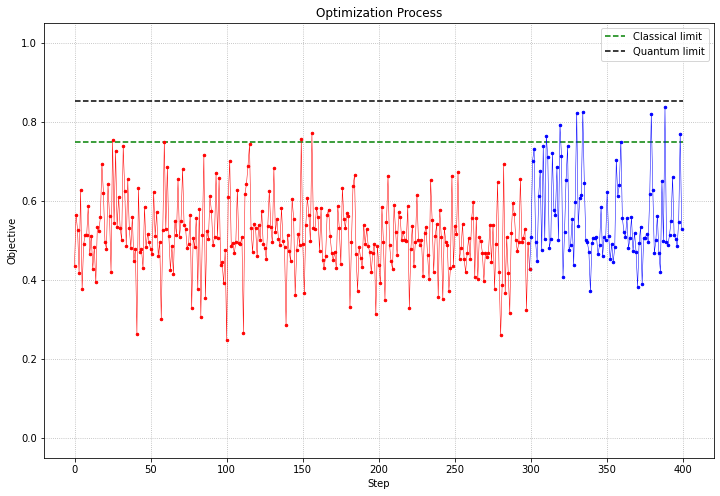

In [ ]:
pbounds = {'x00': (0, 2 * np.pi), 
           'x01': (0, 2 * np.pi), 
           'x02': (0, 2 * np.pi), 
           'x03': (0, 2 * np.pi),
           'x04': (-2, 2), 
           'x05': (-2, 2), 
           'x06': (-2, 2)}

optimizer = BayesianOptimization(
    f=simulate_vqc,
    pbounds=pbounds,
    verbose=1,
    random_state=RANDOM_SEED,
)

start = time()
optimizer.maximize(
    init_points=INIT_P,
    acq='poi',
    n_iter=ITER,
)
end = time()

print(f"\nOptimum = {optimizer.max}")

print(f"\nTook {round((end - start)/ 60, 2)} min\n")

plot_target(optimizer=optimizer, init_p=INIT_P, iter=ITER)

In [ ]:
best_params = optimizer.max["params"]
(x00, x01, x02, x03, x04, x05, x06) = best_params.values()

result_ent = simulate_vqc(x00, x01, x02, x03, x04, x05, x06)
print(f"Best result obtained (with entanglement): {result_ent}")

Best result obtained (with entanglement): 0.818
